In [48]:
%matplotlib inline
%matplotlib notebook
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


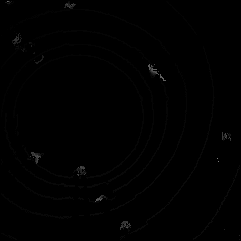

In [19]:
with Image.open("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_lidar_bev/bev4.png") as img:
    display(img)

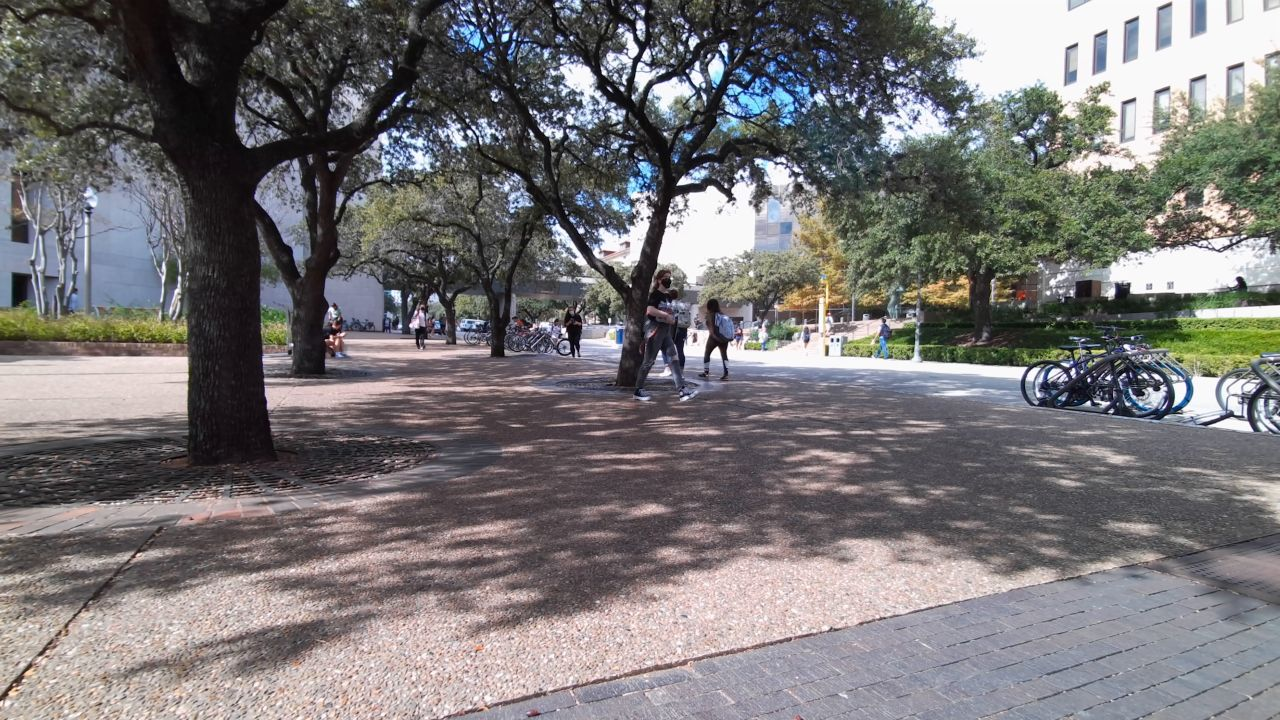

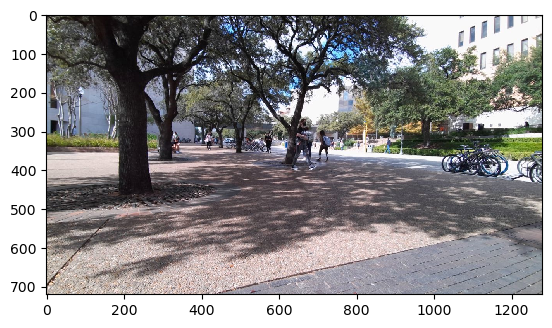

In [21]:
with Image.open("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_rgb_img/img0.png") as img:
    display(img)
    plt.imshow(img)

In [31]:
bev_frms = [file for file in os.listdir("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_lidar_bev")]
len(bev_frms)

2062

<IPython.core.display.Javascript object>


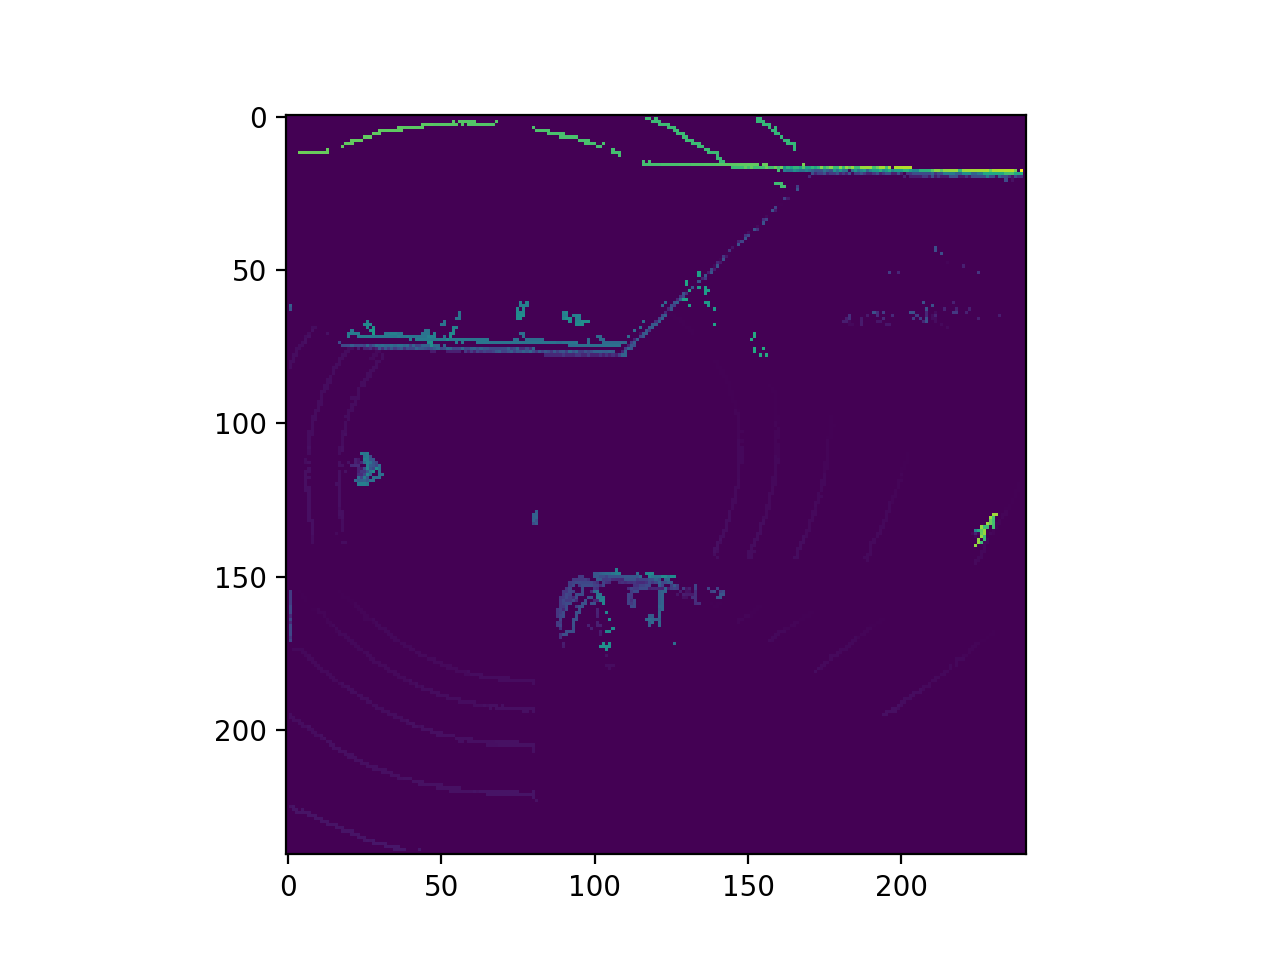

In [49]:
fig, ax = plt.subplots()
ims = []

for i in range(len(bev_frms)):
    with Image.open(f"./data/A_Spot_Library_Dobie_Wed_Nov_10_57_lidar_bev/bev{i}.png") as img:
        im = ax.imshow(img, animated=True)
        if i == 0:
            ax.imshow(img)  # show an initial one first
        ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.show()